# Find_Mask man
- 출처 : https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

## Module Import

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import tensorflow as tf
from tensorflow.keras import Sequential, models, layers, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Data collecting

### 데이터 경로와 목록 저장

In [4]:
path = "../data/Face Mask Dataset/"
dataset = {"image_path":[], "mask_status":[], "where":[]}

for where in os.listdir(path):
    for status in os.listdir(path + "/" + where):
        for image in glob.glob(path + "/" + where + "/" + status + "/" + "*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,../data/Face Mask Dataset/Test/WithMask\1163.png,WithMask,Test
1,../data/Face Mask Dataset/Test/WithMask\1174.png,WithMask,Test
2,../data/Face Mask Dataset/Test/WithMask\1175.png,WithMask,Test
3,../data/Face Mask Dataset/Test/WithMask\1203.png,WithMask,Test
4,../data/Face Mask Dataset/Test/WithMask\1361.png,WithMask,Test


With Mask: 5909
Without Mask: 5883


<Axes: xlabel='mask_status', ylabel='count'>

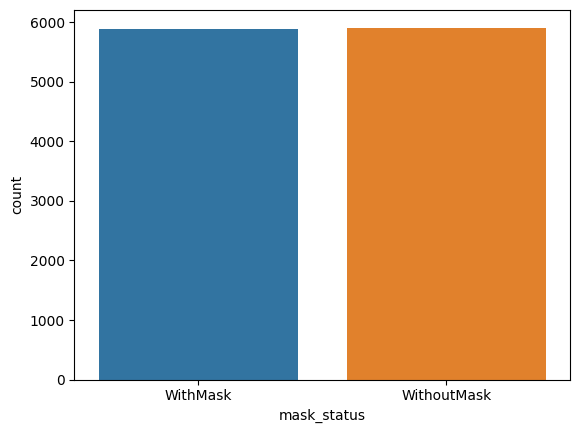

In [5]:
print("With Mask:", dataset.value_counts("mask_status")[0])
print("Without Mask:", dataset.value_counts("mask_status")[1])

sns.countplot(x=dataset["mask_status"])

### 이미지 데이터 확인

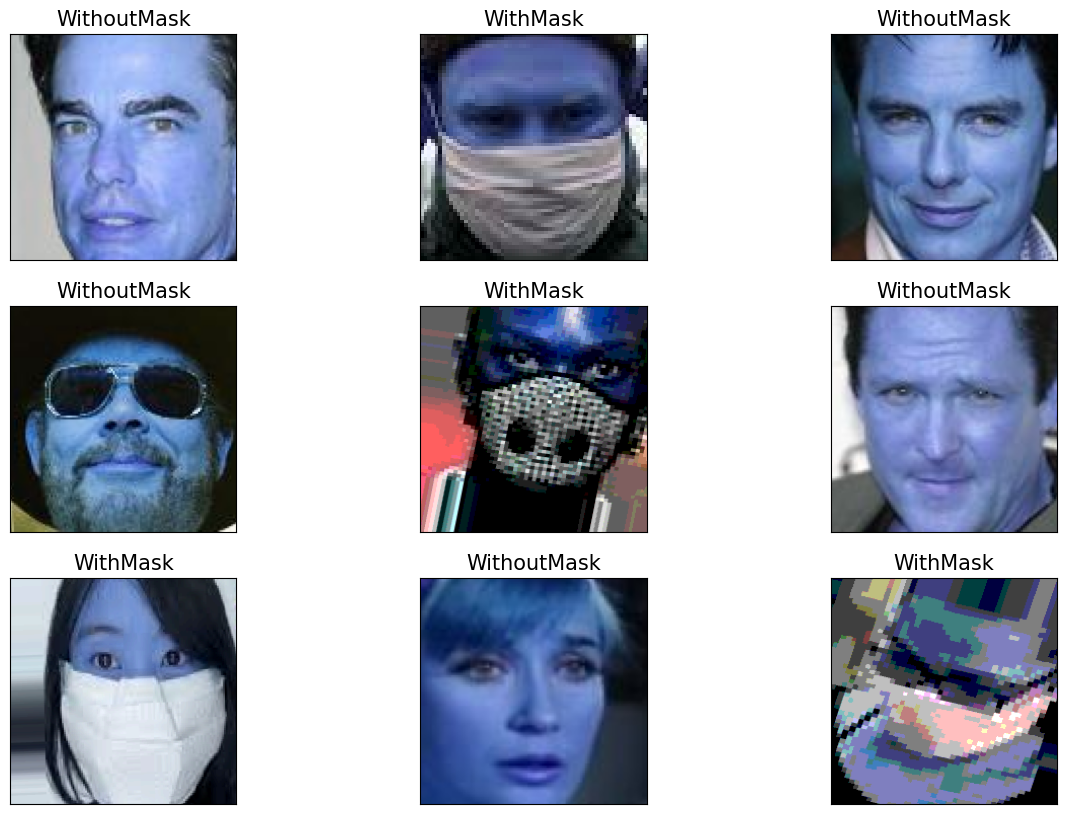

In [10]:
import cv2

plt.figure(figsize=(15,10))
for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))
    plt.title(dataset.loc[random, "mask_status"], size=15)
    plt.xticks([]); plt.yticks([])
plt.show()

In [16]:
train_df = dataset[dataset["where"]=="Train"]
test_df = dataset[dataset["where"]=="Test"]
valid_df = dataset[dataset["where"]=="Validation"]

train_df.head()

,image_path,mask_status,where
992,../data/Face Mask Dataset/Train/WithMask\10.png,WithMask,Train
993,../data/Face Mask Dataset/Train/WithMask\100.png,WithMask,Train
994,../data/Face Mask Dataset/Train/WithMask\1004.png,WithMask,Train
995,../data/Face Mask Dataset/Train/WithMask\1005.png,WithMask,Train
996,../data/Face Mask Dataset/Train/WithMask\1006.png,WithMask,Train


Text(0.5, 1.0, 'Validation Dataset')

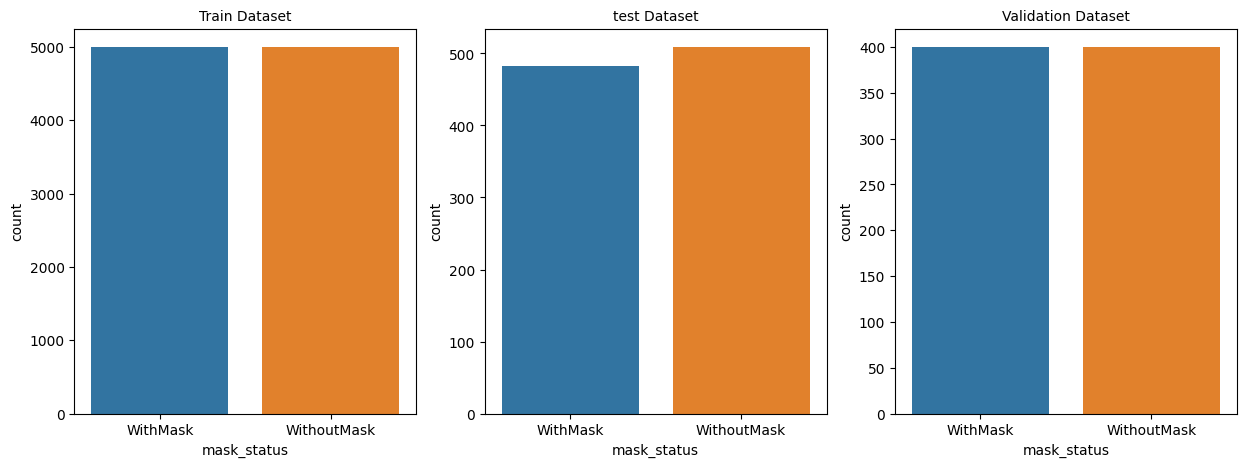

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.countplot(x=train_df["mask_status"])
plt.title("Train Dataset", size=10)

plt.subplot(132)
sns.countplot(x=test_df["mask_status"])
plt.title("test Dataset", size=10)

plt.subplot(133)
sns.countplot(x=valid_df["mask_status"])
plt.title("Validation Dataset", size=10)


## Data preprocessing

#### 인덱스 초기화

In [21]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,image_path,mask_status,where
0,../data/Face Mask Dataset/Train/WithMask\10.png,WithMask,Train
1,../data/Face Mask Dataset/Train/WithMask\100.png,WithMask,Train
2,../data/Face Mask Dataset/Train/WithMask\1004.png,WithMask,Train
3,../data/Face Mask Dataset/Train/WithMask\1005.png,WithMask,Train
4,../data/Face Mask Dataset/Train/WithMask\1006.png,WithMask,Train


#### 이미지 전처리

In [22]:
data = []
image_size = 150

for i in range(len(train_df)):
    # Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)
    
    # Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))
    
    # Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [24]:
np.random.shuffle(data)
data[0]

[array([[ 76,  65,  61, ..., 111, 108, 111],
        [ 76,  64,  61, ..., 110, 108, 111],
        [ 75,  63,  61, ..., 110, 108, 111],
        ...,
        [ 11,   6,  15, ...,  70,  70,  70],
        [ 10,   6,  17, ...,  70,  70,  70],
        [ 10,   8,  18, ...,  70,  70,  70]], dtype=uint8),
 1]

### 전처리 데이터 확인

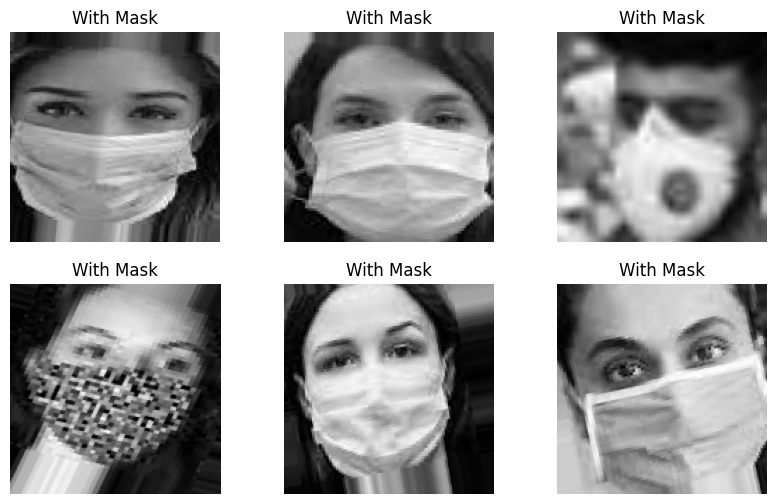

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(10,6))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col
        
        ax[row, col].axis("off")
        ax[row, col].imshow(data[image_index][0], cmap="gray")
        
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")

---

---

## Modeling

### 모델 학습

In [43]:
X = []
y = []
for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [44]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu", input_shape=(150,150,1)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, kernel_size=(2,2), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation="relu"),
    layers.Dense(1, activation="sigmoid")              
])

model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
history = model.fit(X_train, y_train, epochs=4, batch_size=32)

Epoch 1/4
250/250 [==============================] - 317s 1s/step - loss: 25.5447 - accuracy: 0.8960
Epoch 2/4
250/250 [==============================] - 393s 2s/step - loss: 0.0632 - accuracy: 0.9758
Epoch 3/4
250/250 [==============================] - 379s 2s/step - loss: 0.0300 - accuracy: 0.9894
Epoch 4/4
250/250 [==============================] - 391s 2s/step - loss: 0.0185 - accuracy: 0.9933


#### Colab GPU 사용시 학습속도
![image](https://user-images.githubusercontent.com/118172599/235179966-4c4b29f9-3aec-4a22-b8d3-e0bfd0bdb648.png)

---

## 모델 평가
### 모델 성능 확인

In [45]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 16s 253ms/step - loss: 0.1214 - accuracy: 0.9660


[0.12140300869941711, 0.9660000205039978]

In [46]:
prediction = (model.predict(X_val) > 0.5).astype("int32")

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 14s 222ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1032
           1       0.97      0.96      0.96       968

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[1001   31]
 [  37  931]]


### 틀린데이터 확인

In [47]:
wrong_result = []

for n in range(y_val.shape[0]):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)

len(wrong_result)

68

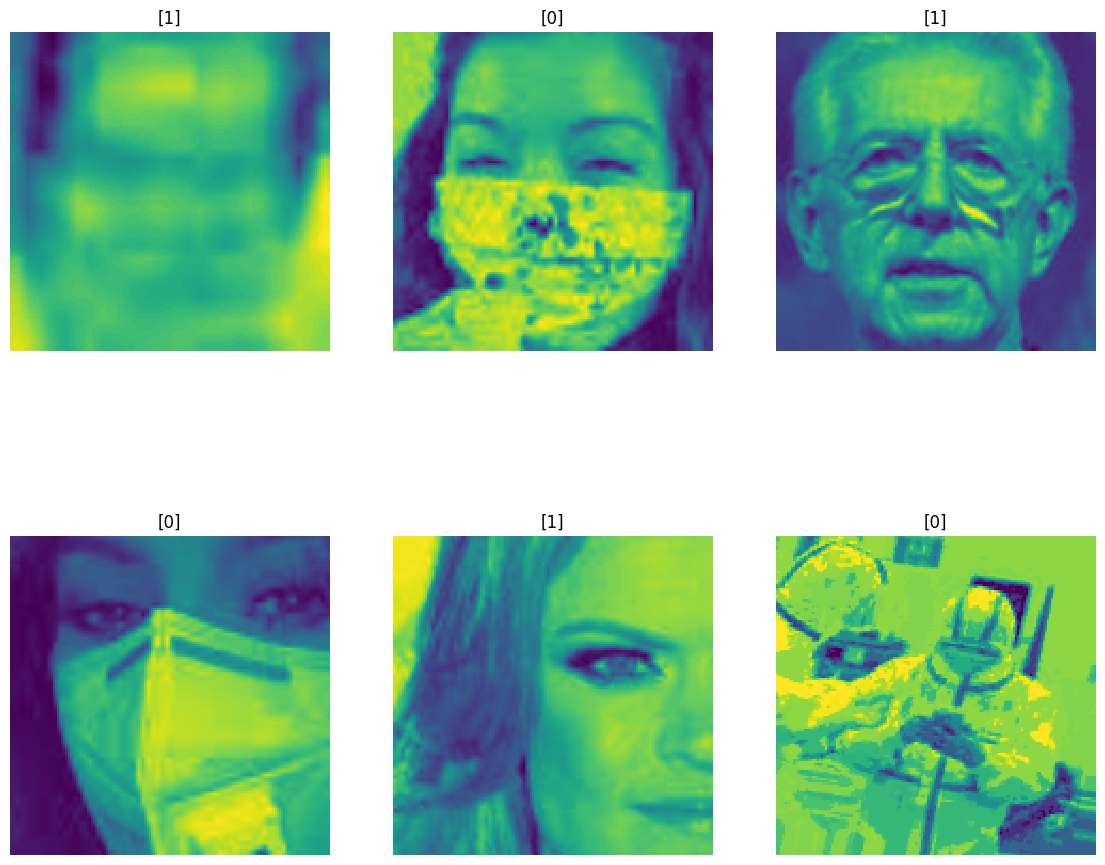

In [52]:
import random

samples = random.choices(population=wrong_result, k=6)

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
    plt.subplot(2, 3, idx+1)
    plt.imshow(X_val[n].reshape(150, 150),interpolation="nearest")
    plt.title(prediction[n])
    plt.axis("off")